Los datos cargados contienen las series de tiempo originales junto con la asignación de grupo (cluster) para cada cliente. Esto nos permite reutilizar el conjunto de datos procesado en futuras fases del proyecto, como el entrenamiento de modelos predictivos por grupo.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from itertools import product

df = pd.read_parquet('base_anomalias_cluster.parquet')

# Mostrar dimensiones del dataset
print(f"Dimensiones del dataset: {df.shape}")

# Mostrar tipos de datos y primeras filas
print("\nTipos de datos:")
print(df.dtypes)

# Verificar valores nulos
print("\nConteo de valores nulos por columna:")
print(df.isnull().sum())

# Estadísticas descriptivas de las variables principales
variables_principales = ['presion', 'volumen', 'temperatura', 'cluster', 'es_anomalia_IQR_local']
print("\nResumen estadístico de las variables principales:")
print(df[variables_principales].describe())

Dimensiones del dataset: (847969, 12)

Tipos de datos:
K                                 int64
ID                                int64
time                     datetime64[ns]
presion                         float64
temperatura                     float64
volumen                         float64
mes                               int32
dia                               int32
hora                              int32
PV                              float64
cluster                           int64
es_anomalia_IQR_local           float64
dtype: object

Conteo de valores nulos por columna:
K                        0
ID                       0
time                     0
presion                  0
temperatura              0
volumen                  0
mes                      0
dia                      0
hora                     0
PV                       0
cluster                  0
es_anomalia_IQR_local    0
dtype: int64

Resumen estadístico de las variables principales:
             presion     

## División de los datos por cliente
A continuación se particiona el conjunto de datos por cliente, respetando la estructura de la serie temporal.

Para cada cliente identificado por la columna id, se divide su historial en tres subconjuntos: 70% para entrenamiento con los primeros datos, 20% para prueba y 10% para validación.

Esta división temporal garantiza que no exista filtración de información futura en fases de entrenamiento, manteniendo la validez del proceso de modelado.

In [25]:
df['presion_volumen_ratio'] = df['presion'] / (df['volumen'] + 1e-3)
df['temp_volumen_ratio'] = df['temperatura'] / (df['volumen'] + 1e-3)
df['hora_pico'] = df['hora'].apply(lambda h: 1 if 7 <= h <= 19 else 0)

# Crear listas para almacenar los conjuntos
df_train = []
df_test = []
df_val = []

# Dividir por cliente (id)
for cliente_id, grupo in df.groupby("ID"):
    grupo = grupo.sort_values("time")  # Ordenar por fecha

    n = len(grupo)
    n_train = int(n * 0.7)
    n_test = int(n * 0.2)

    df_train.append(grupo.iloc[:n_train])
    df_test.append(grupo.iloc[n_train:n_train + n_test])
    df_val.append(grupo.iloc[n_train + n_test:])

# Unir todos los subconjuntos
train = pd.concat(df_train).reset_index(drop=True)
test = pd.concat(df_test).reset_index(drop=True)
val = pd.concat(df_val).reset_index(drop=True)

# Mostrar dimensiones
print(f"Train: {train.shape}, Test: {test.shape}, Validation: {val.shape}")

Train: (593567, 15), Test: (169587, 15), Validation: (84815, 15)


In [27]:
print(train['es_anomalia_IQR_local'].value_counts())
print(test['es_anomalia_IQR_local'].value_counts())
print(val['es_anomalia_IQR_local'].value_counts())

es_anomalia_IQR_local
0.0    527166
1.0     66401
Name: count, dtype: int64
es_anomalia_IQR_local
0.0    140292
1.0     29295
Name: count, dtype: int64
es_anomalia_IQR_local
0.0    44288
1.0    40527
Name: count, dtype: int64


Cluster: 0
Número total de mediciones: 84496
Número total de anomalías: 2549
Porcentaje de anomalías: 0.030167


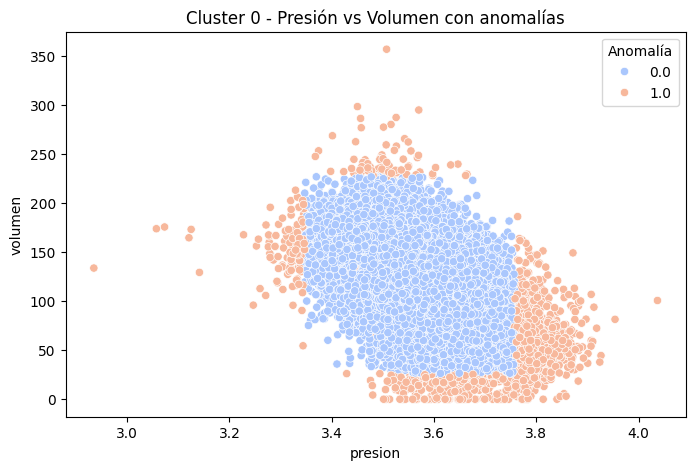

Cluster: 1
Número total de mediciones: 171910
Número total de anomalías: 87
Porcentaje de anomalías: 0.000506


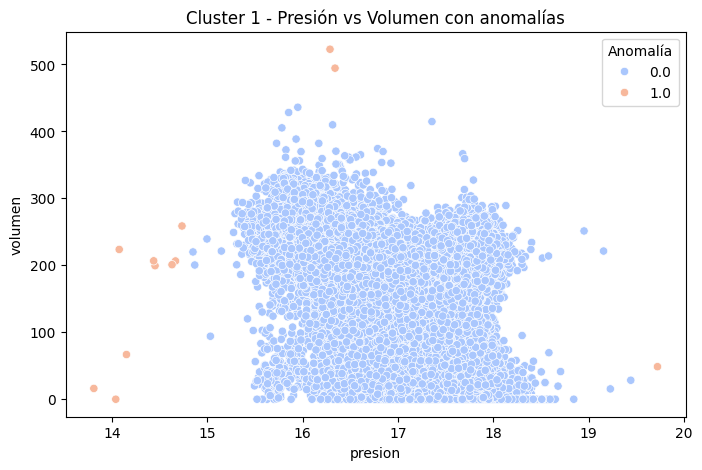

Cluster: 2
Número total de mediciones: 86832
Número total de anomalías: 16910
Porcentaje de anomalías: 0.194744


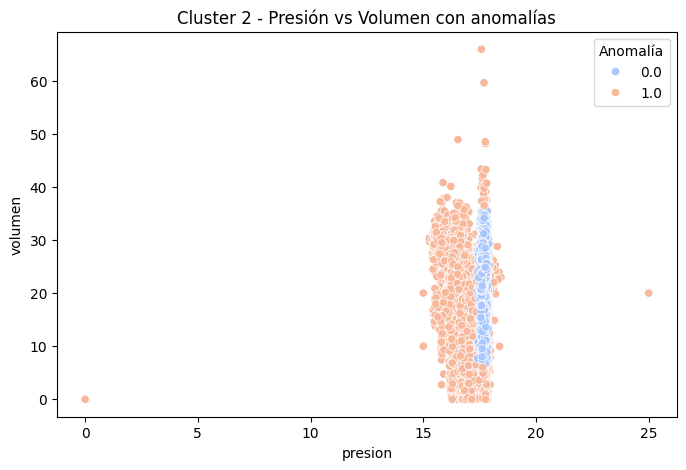

Cluster: 3
Número total de mediciones: 82764
Número total de anomalías: 14746
Porcentaje de anomalías: 0.178169


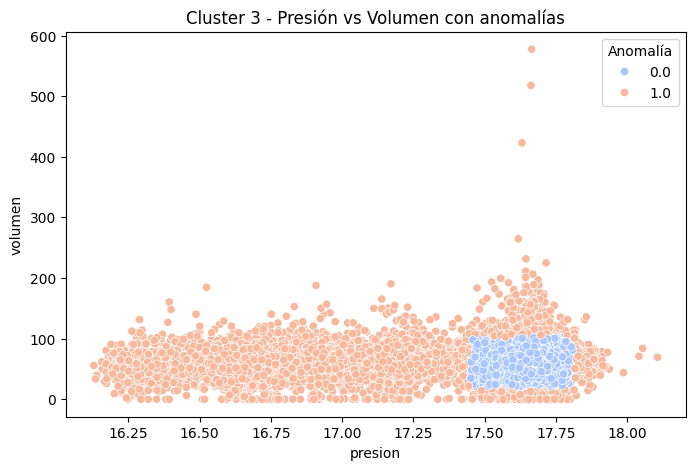

Cluster: 4
Número total de mediciones: 85191
Número total de anomalías: 26628
Porcentaje de anomalías: 0.312568


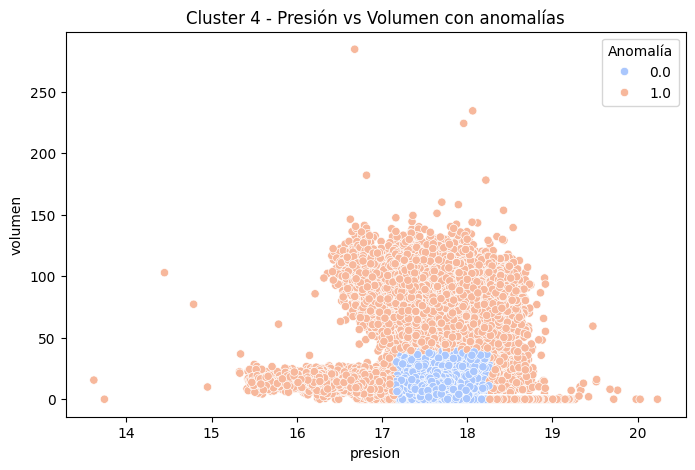

Cluster: 5
Número total de mediciones: 85191
Número total de anomalías: 20846
Porcentaje de anomalías: 0.244697


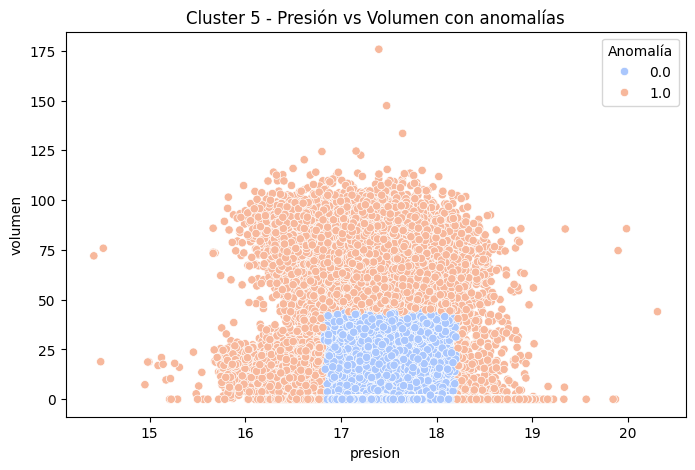

Cluster: 6
Número total de mediciones: 84610
Número total de anomalías: 29923
Porcentaje de anomalías: 0.353658


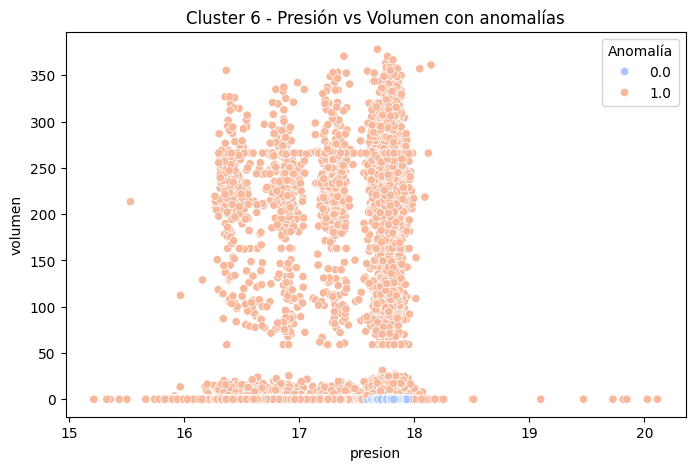

Cluster: 7
Número total de mediciones: 83487
Número total de anomalías: 12674
Porcentaje de anomalías: 0.151808


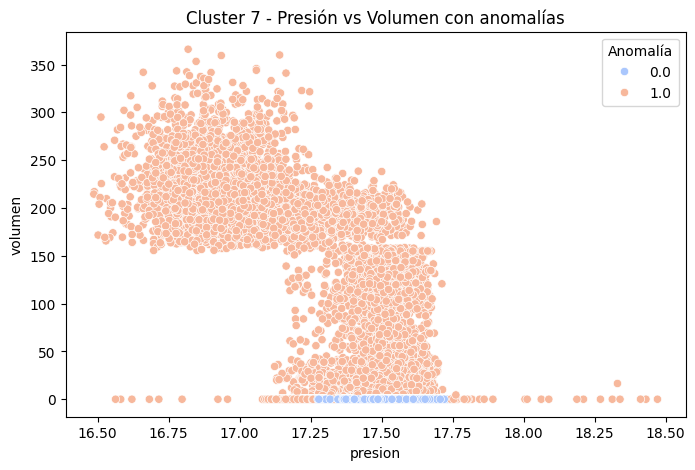

Cluster: 8
Número total de mediciones: 83488
Número total de anomalías: 11860
Porcentaje de anomalías: 0.142056


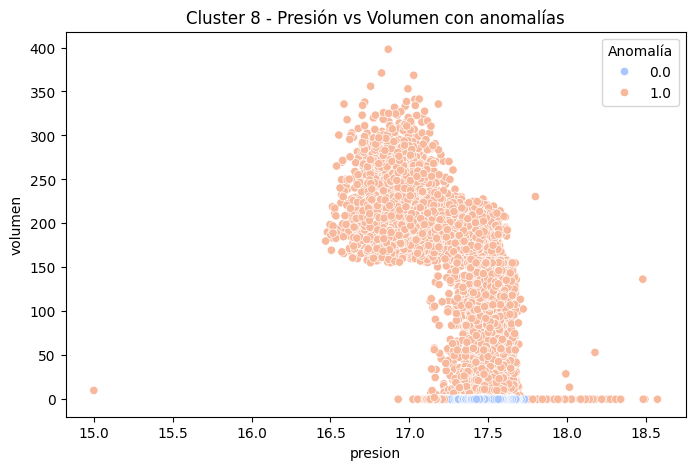

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

for c in sorted(df['cluster'].unique()):
    subset = df[df['cluster'] == c]

    print(f"Cluster: {c}")
    print(f"Número total de mediciones: {len(subset)}")
    print(f"Número total de anomalías: {len(subset[subset['es_anomalia_IQR_local'] == 1])}")
    print(f"Porcentaje de anomalías: {len(subset[subset['es_anomalia_IQR_local'] == 1]) / len(subset):.6f}")

    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=subset, x='presion', y='volumen', hue='es_anomalia_IQR_local', palette='coolwarm')
    plt.title(f"Cluster {c} - Presión vs Volumen con anomalías")
    plt.legend(title='Anomalía')
    plt.show()

### Detección de anomalías con Isolation Forest por cluster

En esta etapa se aplicará el algoritmo **Isolation Forest** para la detección de anomalías en el comportamiento del consumo de gas. Considerando que los clientes han sido agrupados previamente en 8 clusters con características de consumo similares, se entrenará un modelo por cada cluster, con el objetivo de especializar la detección de patrones atípicos según el tipo de cliente.

El proceso es el siguiente:

- **Entrenamiento**: Se utilizará el conjunto de datos de entrenamiento correspondiente a cada cluster.
- **Evaluación**: Se probará el desempeño de cada modelo con los datos de prueba.
- **Validación**: Se utilizará el conjunto de validación para verificar la robustez de la detección.
- **Ajuste de Hiperparámetros**: Se empleará una búsqueda en rejilla (**GridSearch**) sobre parámetros relevantes del algoritmo como:
  - `n_estimators`: número de árboles en el bosque.
  - `max_samples`: número de muestras para entrenar cada árbol.
  - `contamination`: proporción esperada de anomalías en los datos.
  - `max_features`: número de características usadas por cada árbol.

Este enfoque busca mejorar la precisión del sistema de detección de anomalías, asegurando que cada modelo esté adaptado al comportamiento específico del grupo de clientes que representa.




 **Procesando Cluster 0
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Test classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86     16784
         1.0       0.03      0.98      0.05       114

    accuracy                           0.75     16898
   macro avg       0.51      0.87      0.45     16898
weighted avg       0.99      0.75      0.85     16898

Matriz de Confusión:
[[12586  4198]
 [    2   112]]

Validación classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      8419
         1.0       0.13      1.00      0.23        33

    accuracy                           0.97      8452
   macro avg       0.57      0.99      0.61      8452
weighted avg       1.00      0.97      0.98      8452

Matriz de Confusión:
[[8200  219]
 [   0   33]]

 **Procesando Cluster 1
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Test classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78     34353
         1.0       0.00      1.00      0.00        27

    accuracy                           0.64     34380
   macro avg       0.50      0.82      0.39     34380
weighted avg       1.00      0.64      0.78     34380

Matriz de Confusión:
[[21850 12503]
 [    0    27]]

Validación classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.45      0.62     17194
         1.0       0.00      1.00      0.00         2

    accuracy                           0.45     17196
   macro avg       0.50      0.72      0.31     17196
weighted avg       1.00      0.45      0.62     17196

Matriz de Confusión:
[[7710 9484]
 [   0    2]]

 **Procesando Cluster 2
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Test classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.89     12925
         1.0       0.65      0.98      0.78      4441

    accuracy                           0.86     17366
   macro avg       0.82      0.90      0.84     17366
weighted avg       0.90      0.86      0.86     17366

Matriz de Confusión:
[[10552  2373]
 [  106  4335]]

Validación classification report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      8685

    accuracy                           1.00      8685
   macro avg       1.00      1.00      1.00      8685
weighted avg       1.00      1.00      1.00      8685

Matriz de Confusión:
[[8685]]

 **Procesando Cluster 3


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Test classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     12782
         1.0       0.74      1.00      0.85      3770

    accuracy                           0.92     16552
   macro avg       0.87      0.95      0.90     16552
weighted avg       0.94      0.92      0.92     16552

Matriz de Confusión:
[[11462  1320]
 [    1  3769]]

Validación classification report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      8278

    accuracy                           1.00      8278
   macro avg       1.00      1.00      1.00      8278
weighted avg       1.00      1.00      1.00      8278

Matriz de Confusión:
[[8278]]

 **Procesando Cluster 4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Test classification report:
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87     11351
         1.0       0.77      0.67      0.72      5687

    accuracy                           0.82     17038
   macro avg       0.81      0.78      0.79     17038
weighted avg       0.82      0.82      0.82     17038

Matriz de Confusión:
[[10212  1139]
 [ 1880  3807]]

Validación classification report:
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      2538
         1.0       0.97      0.97      0.97      5982

    accuracy                           0.96      8520
   macro avg       0.95      0.95      0.95      8520
weighted avg       0.96      0.96      0.96      8520

Matriz de Confusión:
[[2346  192]
 [ 191 5791]]

 **Procesando Cluster 5
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Test classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87     13129
         1.0       0.57      0.70      0.63      3909

    accuracy                           0.81     17038
   macro avg       0.74      0.77      0.75     17038
weighted avg       0.83      0.81      0.82     17038

Matriz de Confusión:
[[11075  2054]
 [ 1192  2717]]

Validación classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85      3110
         1.0       0.87      0.99      0.93      5410

    accuracy                           0.90      8520
   macro avg       0.93      0.87      0.89      8520
weighted avg       0.91      0.90      0.90      8520

Matriz de Confusión:
[[2323  787]
 [  28 5382]]

 **Procesando Cluster 6
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Test classification report:
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89     10198
         1.0       0.89      0.75      0.82      6724

    accuracy                           0.87     16922
   macro avg       0.87      0.85      0.86     16922
weighted avg       0.87      0.87      0.86     16922

Matriz de Confusión:
[[9574  624]
 [1652 5072]]

Validación classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00      8461

    accuracy                           1.00      8462
   macro avg       1.00      1.00      1.00      8462
weighted avg       1.00      1.00      1.00      8462

Matriz de Confusión:
[[   1    0]
 [   0 8461]]

 **Procesando Cluster 7
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Test classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     14372
         1.0       0.75      0.75      0.75      2324

    accuracy                           0.93     16696
   macro avg       0.85      0.86      0.85     16696
weighted avg       0.93      0.93      0.93     16696

Matriz de Confusión:
[[13775   597]
 [  571  1753]]

Validación classification report:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      6617
         1.0       1.00      0.74      0.85      1734

    accuracy                           0.95      8351
   macro avg       0.97      0.87      0.91      8351
weighted avg       0.95      0.95      0.94      8351

Matriz de Confusión:
[[6615    2]
 [ 455 1279]]

 **Procesando Cluster 8
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Test classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     14398
         1.0       0.75      0.77      0.76      2299

    accuracy                           0.93     16697
   macro avg       0.86      0.87      0.86     16697
weighted avg       0.93      0.93      0.93     16697

Matriz de Confusión:
[[13819   579]
 [  526  1773]]

Validación classification report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      6409
         1.0       0.97      0.80      0.88      1942

    accuracy                           0.95      8351
   macro avg       0.96      0.90      0.92      8351
weighted avg       0.95      0.95      0.95      8351

Matriz de Confusión:
[[6368   41]
 [ 381 1561]]


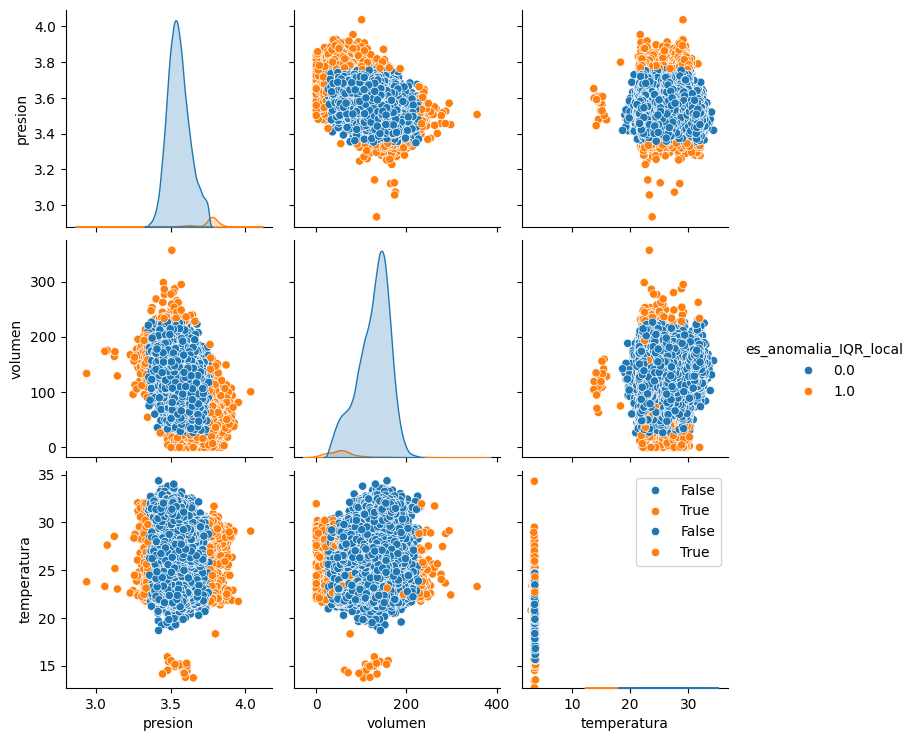

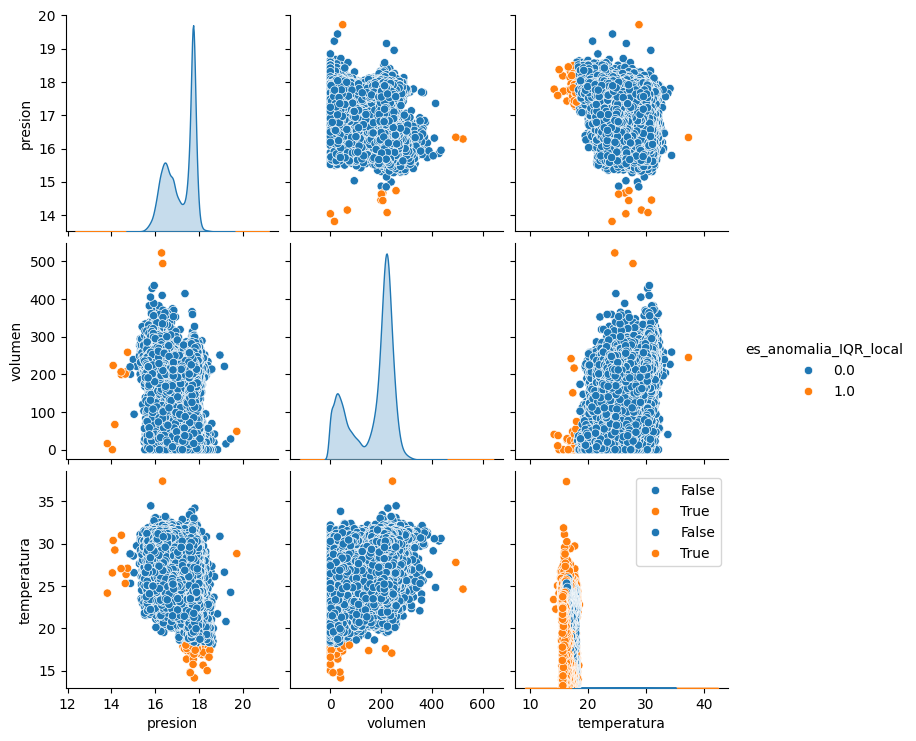

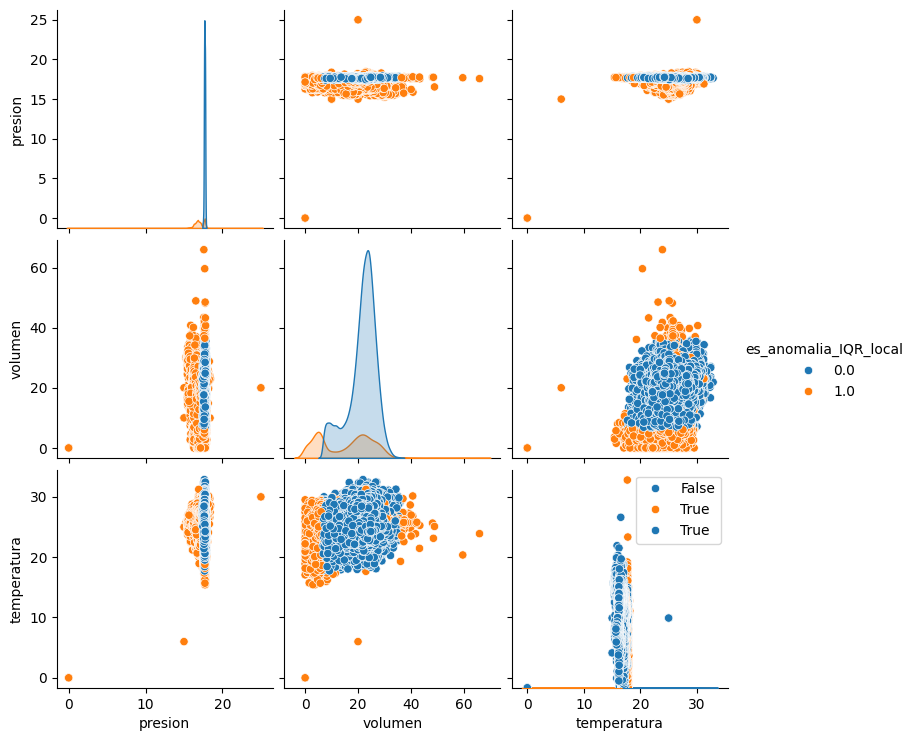

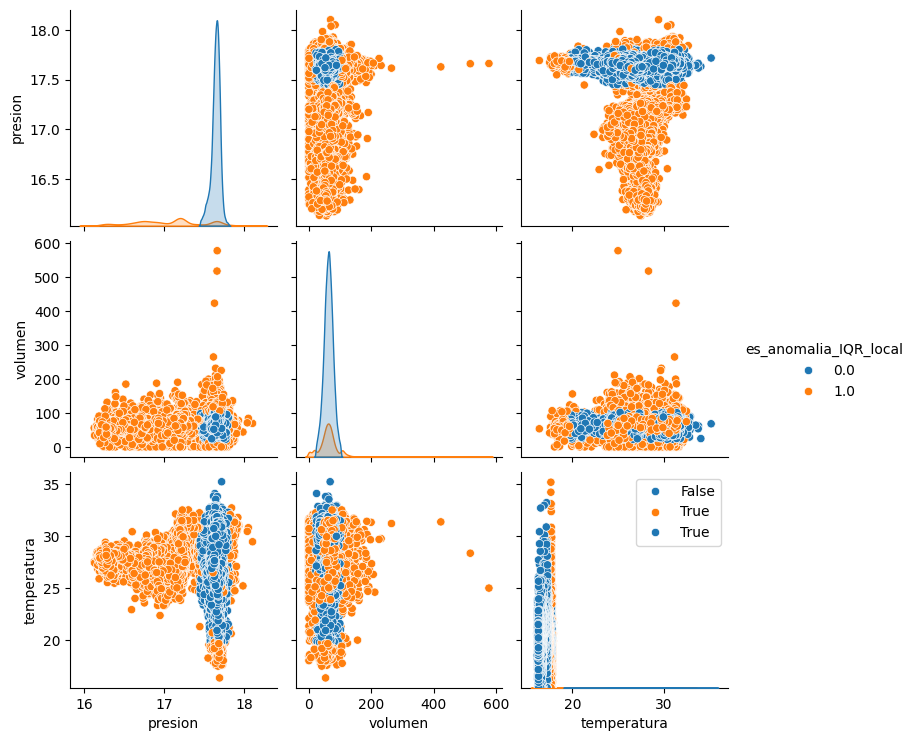

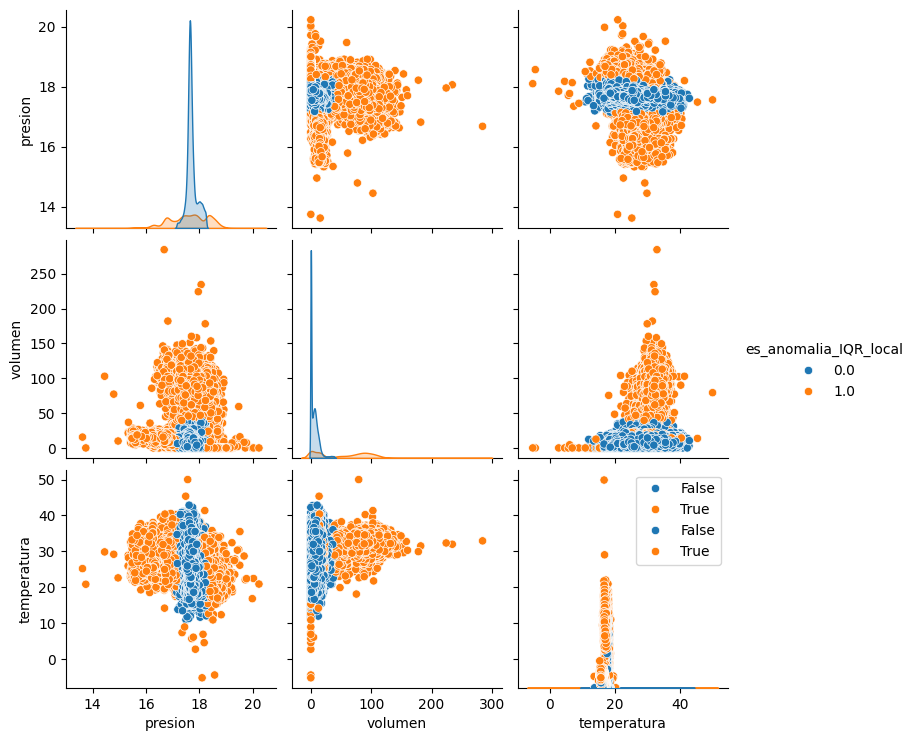

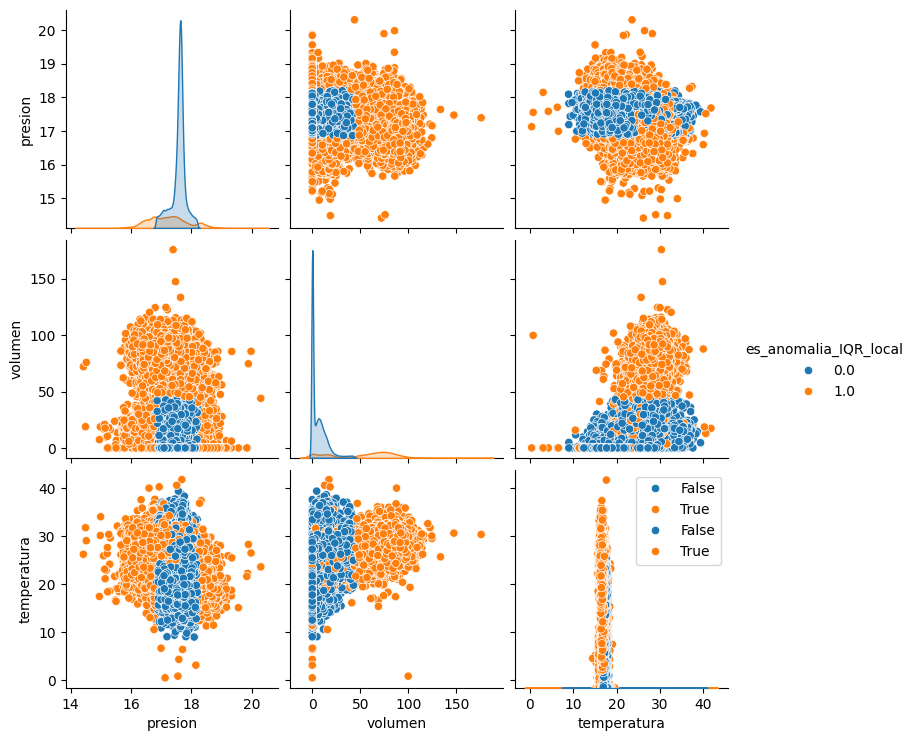

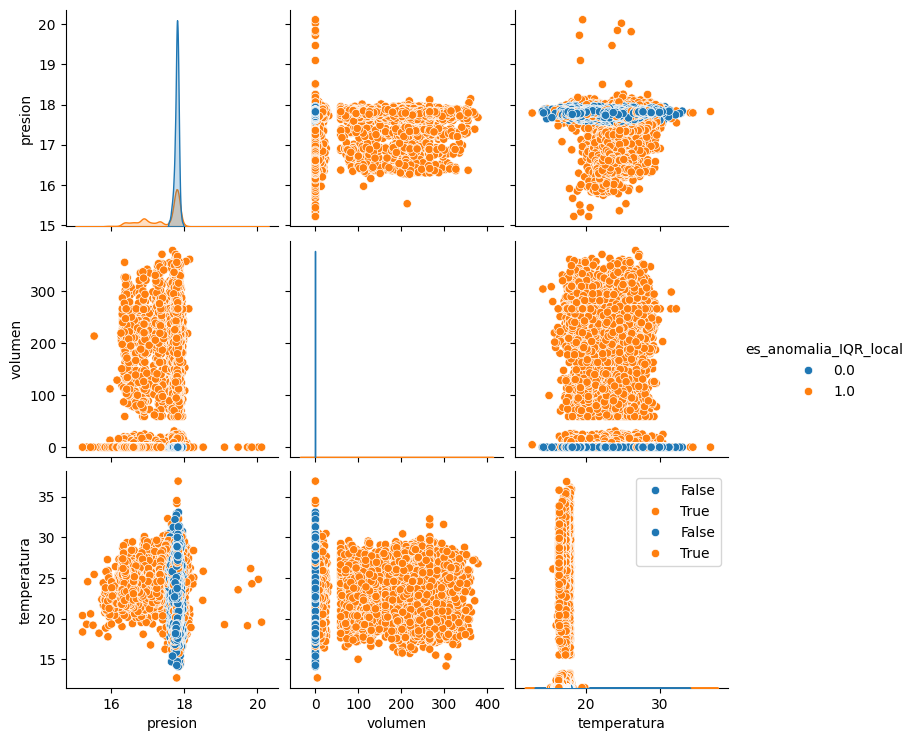

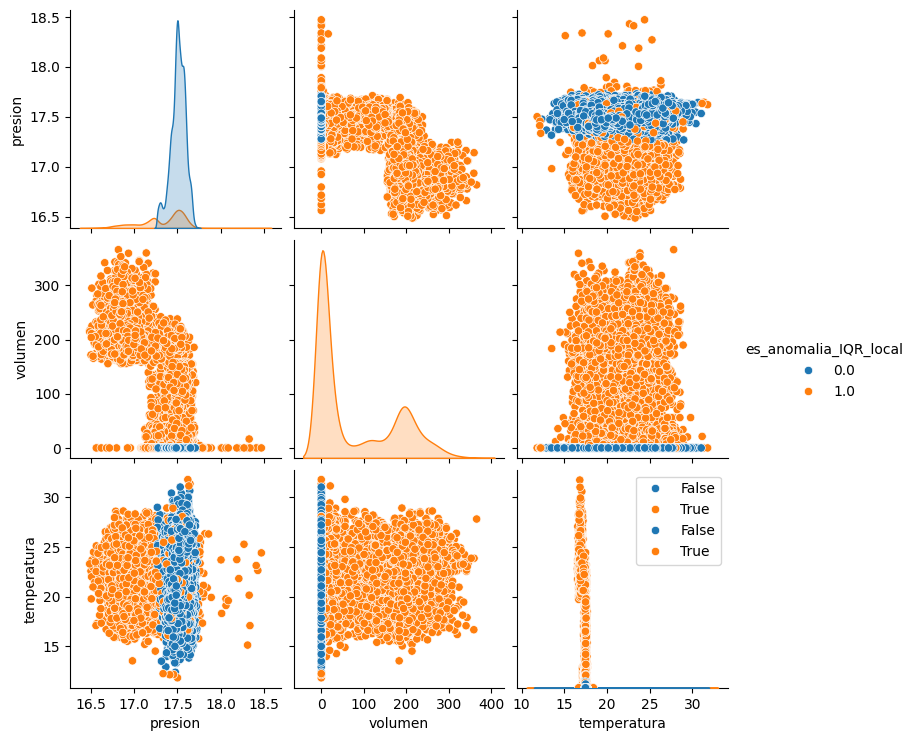

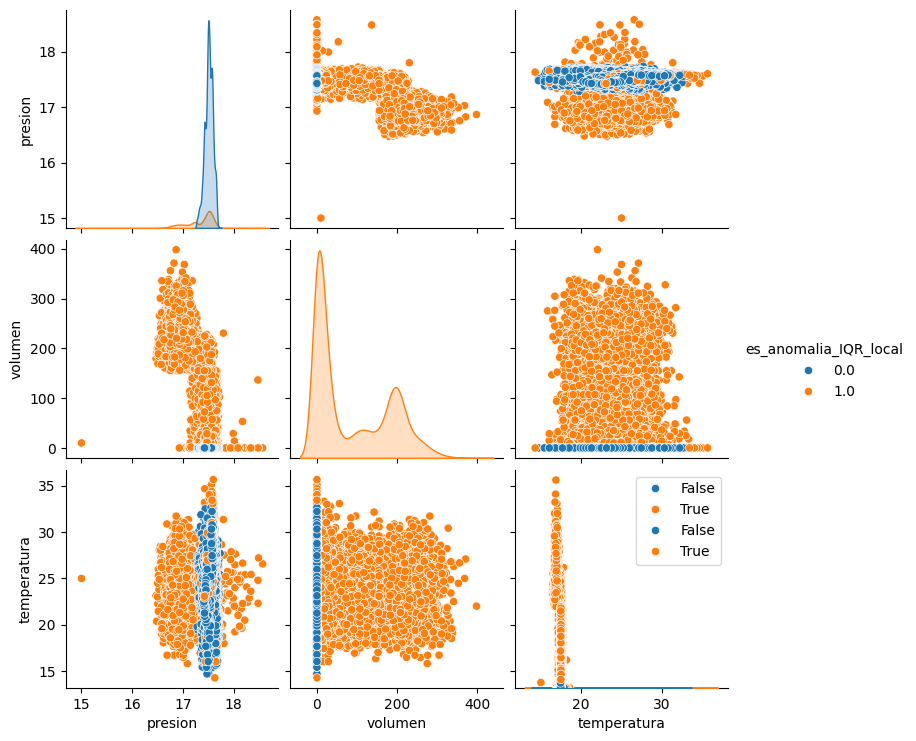

In [42]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Nuevo preprocesamiento de variables derivadas
df['presion_volumen_ratio'] = df['presion'] / (df['volumen'] + 1e-3)
df['temp_volumen_ratio'] = df['temperatura'] / (df['volumen'] + 1e-3)
df['hora_pico'] = df['hora'].apply(lambda h: 1 if 7 <= h <= 19 else 0)

variables_numericas = ['presion', 'volumen', 'temperatura'] #, 'presion_volumen_ratio', 'temp_volumen_ratio']
variables_categoricas = ['mes', 'dia', 'hora_pico']
variables_modelo = variables_numericas #+ variables_categoricas

# Column transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), variables_numericas),
#    ('cat', OneHotEncoder(drop='first'), variables_categoricas)
])

pipe = Pipeline([
    ('preprocess', preprocessor),
    ('iforest', IsolationForest(random_state=42))
])

param_grid = {
    'iforest__n_estimators': [100],
    'iforest__max_samples': ['auto'],
    'iforest__contamination': [0.12, 0.15, 0.18], # [0.05, 0.1, 0.15, 0.2, 0.3], #[0.001, 0.005, 0.01, 0.03],
    'iforest__max_features': [1.0]
}

def custom_anomaly_scorer(y_true, y_pred):
    y_pred_binary = (y_pred == -1).astype(int)
    return f1_score(y_true, y_pred_binary)

scorer = make_scorer(custom_anomaly_scorer, greater_is_better=True)

grid = GridSearchCV(pipe, param_grid, cv=3, scoring=scorer, n_jobs=-1, verbose=1)

modelos_cluster = {}

for c in sorted(df['cluster'].unique()):
    print(f"\n **Procesando Cluster {c}")
    sns.pairplot(df[df['cluster'] == c], hue='es_anomalia_IQR_local', vars=['presion', 'volumen', 'temperatura'])

    train_cluster = train[train['cluster'] == c].copy()
    test_cluster = test[test['cluster'] == c].copy()
    val_cluster = val[val['cluster'] == c].copy()

    # Añadir variables derivadas también a splits
    for df_split in [train_cluster, test_cluster, val_cluster]:
        df_split['presion_volumen_ratio'] = df_split['presion'] / (df_split['volumen'] + 1e-3)
        df_split['temp_volumen_ratio'] = df_split['temperatura'] / (df_split['volumen'] + 1e-3)
        df_split['hora_pico'] = df_split['hora'].apply(lambda h: 1 if 7 <= h <= 19 else 0)

    X_train = train_cluster[variables_modelo]
    y_train = train_cluster['es_anomalia_IQR_local']

    counts = y_train.value_counts()
    if 0 not in counts or 1 not in counts:
        print(f"⚠️ Cluster {c} descartado: clases no balanceadas.")
        continue

    contamination_cluster = df_split['es_anomalia_IQR_local'].mean()
    IsolationForest(contamination=contamination_cluster)
    grid.fit(X_train)
    modelos_cluster[c] = grid.best_estimator_

    for df_split, y_true, name in zip(
        [test_cluster[variables_modelo], val_cluster[variables_modelo]],
        [test_cluster['es_anomalia_IQR_local'], val_cluster['es_anomalia_IQR_local']],
        ['Test', 'Validación']
    ):
        y_pred = modelos_cluster[c].predict(df_split)
        y_pred = np.where(y_pred == -1, 1, 0)

        sns.scatterplot(df_split, x='presion', y='volumen', hue=(y_pred == 1))
        print(f"\n{name} classification report:")
        print(classification_report(y_true, y_pred))
        print("Matriz de Confusión:")
        print(confusion_matrix(y_true, y_pred))

In [43]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np

def optimizar_umbral_por_cluster(df, cluster_col, features, label_col):
    mejores_resultados = []

    for c in df[cluster_col].unique():
        print(f"\nCluster {c}:")
        df_cluster = df[df[cluster_col] == c].copy()

        X = df_cluster[features]
        y_true = df_cluster[label_col]  # 0: normal, 1: anomalía

        # Entrenar Isolation Forest con contamination='auto'
        model = IsolationForest(contamination='auto', random_state=42)
        model.fit(X)

        # Obtener decision function (entre más negativo, más anómalo)
        scores = -model.decision_function(X)

        # Calcular curva Precision-Recall
        precision, recall, thresholds = precision_recall_curve(y_true, scores)

        # Calcular F1 para cada umbral
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]

        print(f"Mejor umbral: {best_threshold:.4f} | F1-score: {best_f1:.4f} | Precision: {precision[best_idx]:.4f} | Recall: {recall[best_idx]:.4f}")

        # Guardar resultados
        mejores_resultados.append({
            'cluster': c,
            'umbral': best_threshold,
            'f1': best_f1,
            'precision': precision[best_idx],
            'recall': recall[best_idx]
        })

        # Opcional: plot de la curva
        plt.figure()
        plt.plot(recall, precision, marker='.', label='Precision-Recall')
        plt.axvline(x=recall[best_idx], color='r', linestyle='--', label='Best F1 Point')
        plt.title(f'Precision-Recall - Cluster {c}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid()
        plt.show()

    return mejores_resultados


Cluster 2:
Mejor umbral: 0.0185 | F1-score: 0.6854 | Precision: 0.6618 | Recall: 0.7108


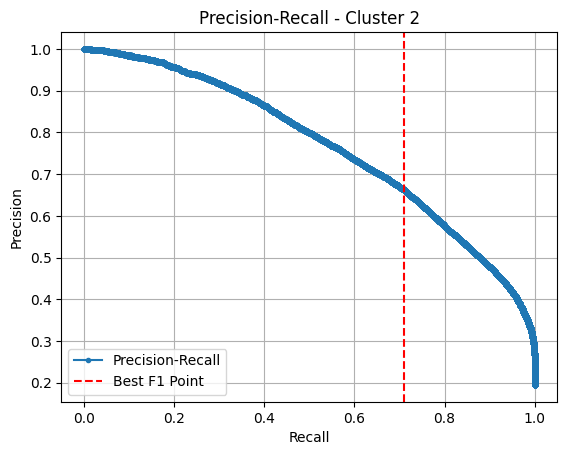


Cluster 3:
Mejor umbral: 0.0153 | F1-score: 0.7166 | Precision: 0.6728 | Recall: 0.7665


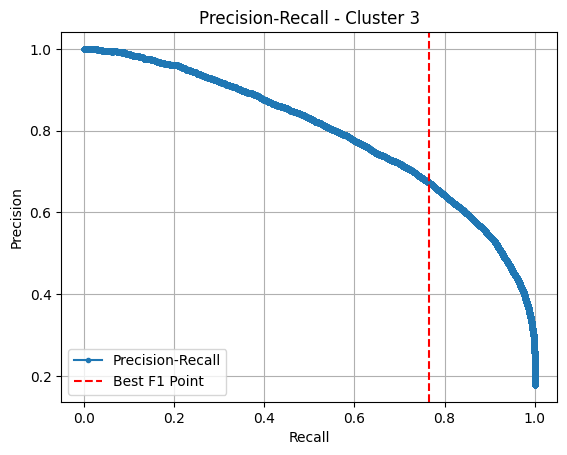


Cluster 0:
Mejor umbral: 0.0663 | F1-score: 0.4712 | Precision: 0.4199 | Recall: 0.5367


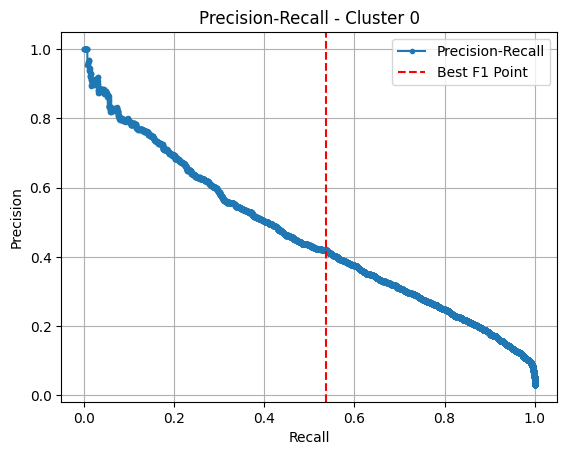


Cluster 6:
Mejor umbral: -0.0171 | F1-score: 0.6897 | Precision: 0.7162 | Recall: 0.6650


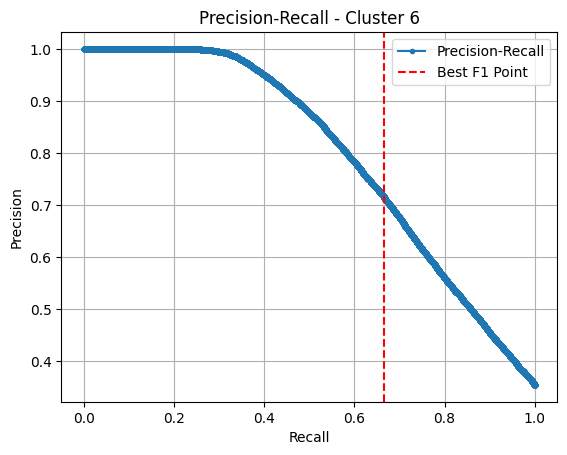


Cluster 5:
Mejor umbral: 0.0174 | F1-score: 0.7886 | Precision: 0.7680 | Recall: 0.8103


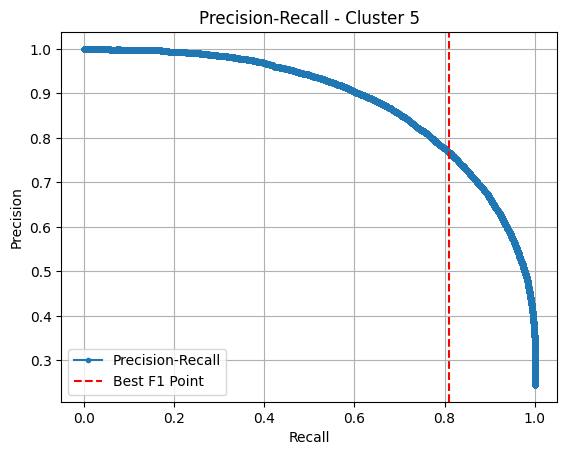


Cluster 1:
Mejor umbral: 0.1085 | F1-score: 0.0279 | Precision: 0.0200 | Recall: 0.0460


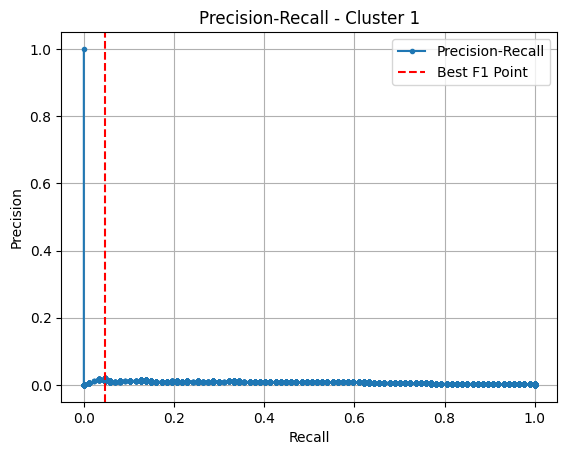


Cluster 7:
Mejor umbral: 0.0227 | F1-score: 0.5973 | Precision: 0.7784 | Recall: 0.4846


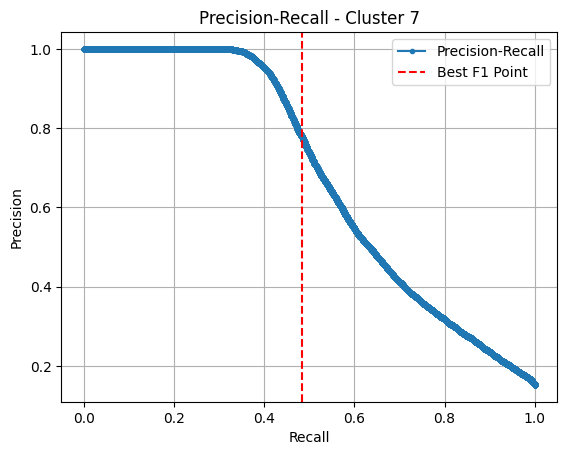


Cluster 8:
Mejor umbral: 0.0226 | F1-score: 0.6529 | Precision: 0.7957 | Recall: 0.5536


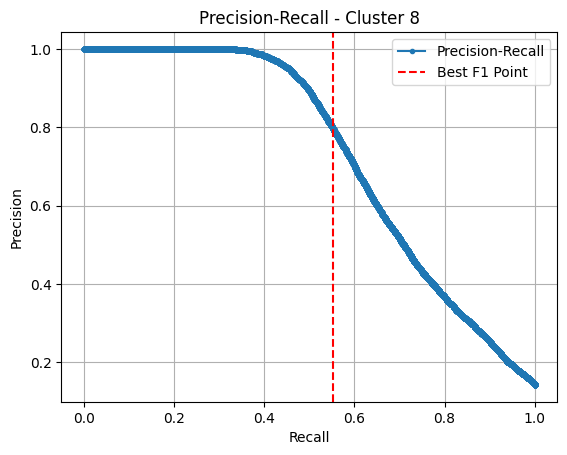


Cluster 4:
Mejor umbral: 0.0088 | F1-score: 0.8032 | Precision: 0.7924 | Recall: 0.8143


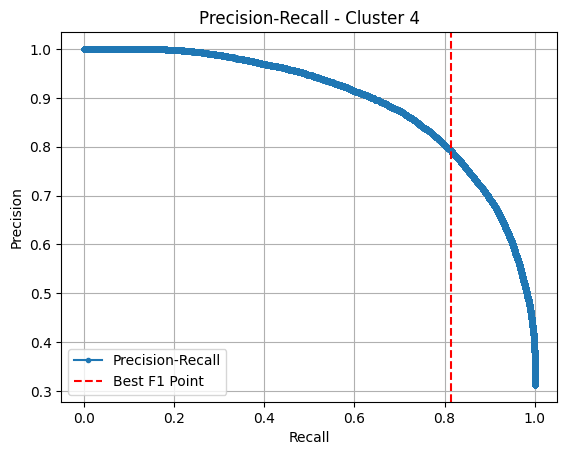

In [44]:
features = ['presion', 'volumen', 'temperatura', 'mes', 'hora', 'dia']
label_col = 'es_anomalia_IQR_local'

resultados = optimizar_umbral_por_cluster(df, 'cluster', features, label_col)


 **Procesando Cluster 0
Cluster 0 – Distribución de clases:
es_anomalia_IQR1_5
1    59146
Name: count, dtype: int64
⚠️ Cluster 0 descartado: clases no balanceadas.

 **Procesando Cluster 1
Cluster 1 – Distribución de clases:
es_anomalia_IQR1_5
0    107573
1     12761
Name: count, dtype: int64
Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


IsolationForest(contamination=0.001, n_estimators=50, random_state=42)


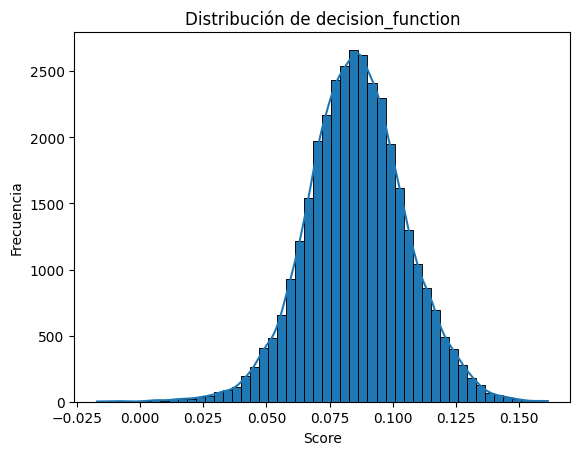

Test classification report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     27064
           1       0.00      0.00      0.00      7316

    accuracy                           0.79     34380
   macro avg       0.39      0.50      0.44     34380
weighted avg       0.62      0.79      0.69     34380

Matriz de Confusión:
[[27050    14]
 [ 7316     0]]
Precisión: 0.0000 | Recall: 0.0000 | F1-score: 0.0000


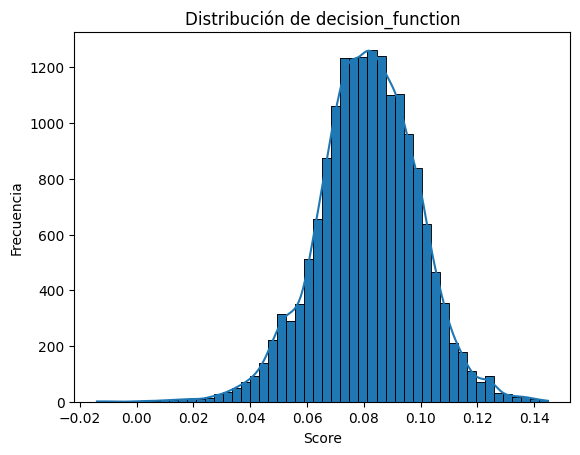

Test classification report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.82     11841
           1       0.00      0.00      0.00      5355

    accuracy                           0.69     17196
   macro avg       0.34      0.50      0.41     17196
weighted avg       0.47      0.69      0.56     17196

Matriz de Confusión:
[[11837     4]
 [ 5355     0]]
Precisión: 0.0000 | Recall: 0.0000 | F1-score: 0.0000

 **Procesando Cluster 2
Cluster 2 – Distribución de clases:
es_anomalia_IQR1_5
0    60781
Name: count, dtype: int64
⚠️ Cluster 2 descartado: clases no balanceadas.

 **Procesando Cluster 3
Cluster 3 – Distribución de clases:
es_anomalia_IQR1_5
0    57930
1        4
Name: count, dtype: int64
Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


IsolationForest(contamination=0.001, n_estimators=50, random_state=42)


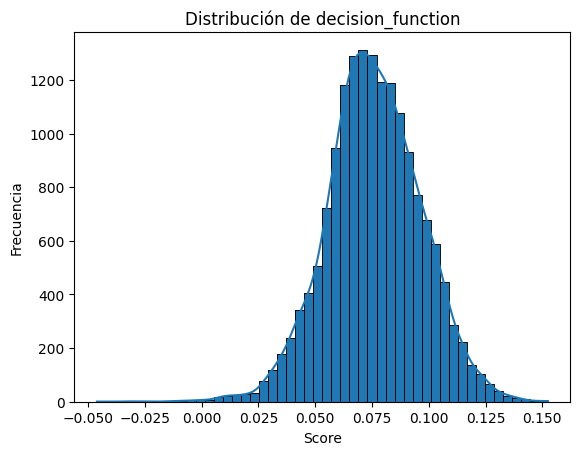

Test classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16552
           1       0.00      0.00      0.00         0

    accuracy                           1.00     16552
   macro avg       0.50      0.50      0.50     16552
weighted avg       1.00      1.00      1.00     16552

Matriz de Confusión:
[[16532    20]
 [    0     0]]
Precisión: 0.0000 | Recall: 0.0000 | F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

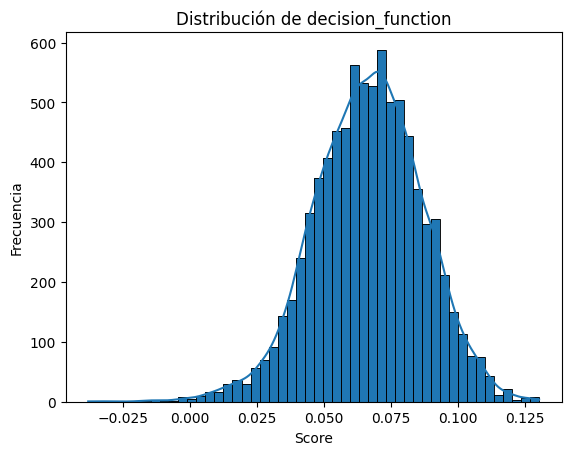

Test classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8234
           1       0.00      0.00      0.00        44

    accuracy                           0.99      8278
   macro avg       0.50      0.50      0.50      8278
weighted avg       0.99      0.99      0.99      8278

Matriz de Confusión:
[[8213   21]
 [  44    0]]
Precisión: 0.0000 | Recall: 0.0000 | F1-score: 0.0000

 **Procesando Cluster 4
Cluster 4 – Distribución de clases:
es_anomalia_IQR1_5
0    56626
1     3007
Name: count, dtype: int64
Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


IsolationForest(contamination=0.001, n_estimators=50, random_state=42)


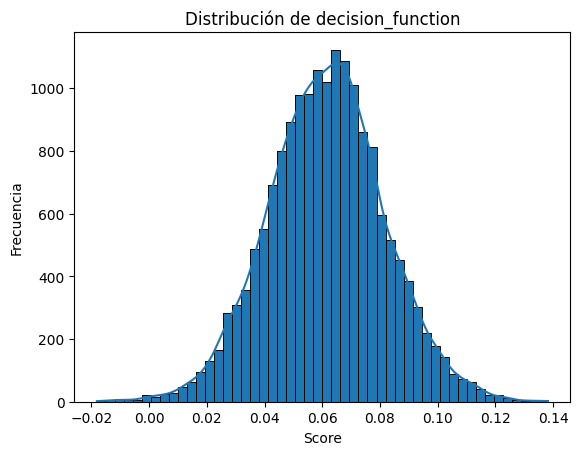

Test classification report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     16137
           1       0.39      0.02      0.03       901

    accuracy                           0.95     17038
   macro avg       0.67      0.51      0.50     17038
weighted avg       0.92      0.95      0.92     17038

Matriz de Confusión:
[[16115    22]
 [  887    14]]
Precisión: 0.3889 | Recall: 0.0155 | F1-score: 0.0299


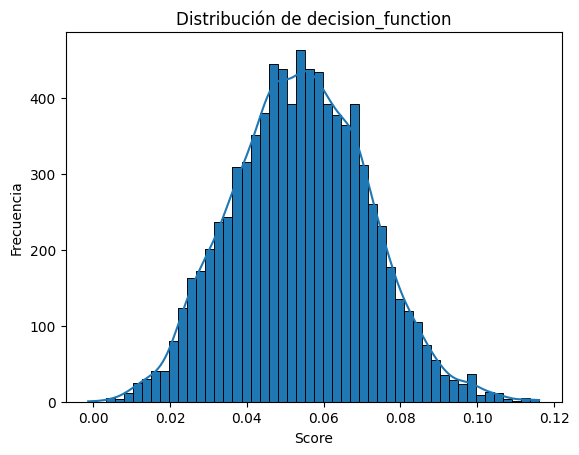

Test classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7881
           1       0.00      0.00      0.00       639

    accuracy                           0.92      8520
   macro avg       0.46      0.50      0.48      8520
weighted avg       0.86      0.92      0.89      8520

Matriz de Confusión:
[[7880    1]
 [ 639    0]]
Precisión: 0.0000 | Recall: 0.0000 | F1-score: 0.0000

 **Procesando Cluster 5
Cluster 5 – Distribución de clases:
es_anomalia_IQR1_5
0    57870
1     1763
Name: count, dtype: int64
Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


IsolationForest(contamination=0.001, n_estimators=50, random_state=42)


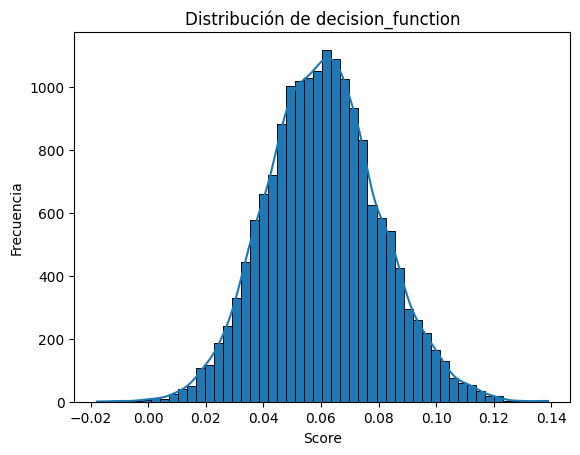

Test classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     16429
           1       0.31      0.01      0.02       609

    accuracy                           0.96     17038
   macro avg       0.64      0.50      0.50     17038
weighted avg       0.94      0.96      0.95     17038

Matriz de Confusión:
[[16418    11]
 [  604     5]]
Precisión: 0.3125 | Recall: 0.0082 | F1-score: 0.0160


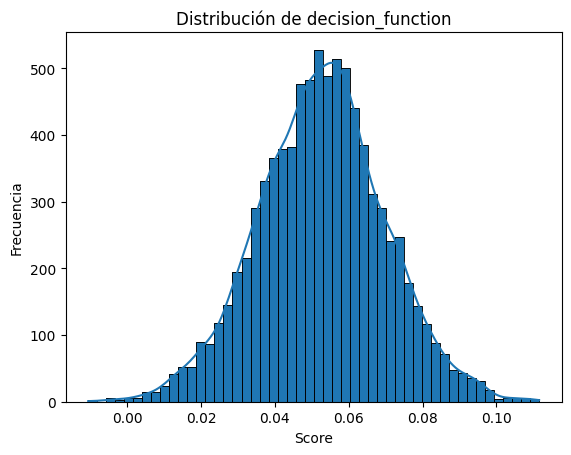

Test classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7878
           1       0.00      0.00      0.00       642

    accuracy                           0.92      8520
   macro avg       0.46      0.50      0.48      8520
weighted avg       0.85      0.92      0.89      8520

Matriz de Confusión:
[[7866   12]
 [ 642    0]]
Precisión: 0.0000 | Recall: 0.0000 | F1-score: 0.0000

 **Procesando Cluster 6
Cluster 6 – Distribución de clases:
es_anomalia_IQR1_5
0    57642
1     1584
Name: count, dtype: int64
Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


IsolationForest(contamination=0.001, n_estimators=50, random_state=42)


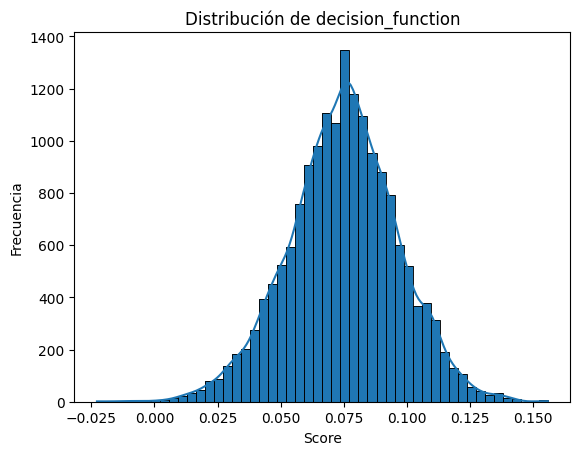

Test classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16538
           1       0.40      0.02      0.03       384

    accuracy                           0.98     16922
   macro avg       0.69      0.51      0.51     16922
weighted avg       0.96      0.98      0.97     16922

Matriz de Confusión:
[[16529     9]
 [  378     6]]
Precisión: 0.4000 | Recall: 0.0156 | F1-score: 0.0301


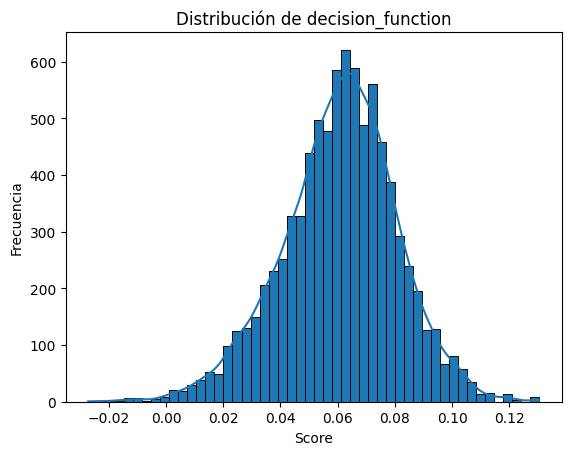

Test classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7832
           1       0.44      0.02      0.03       630

    accuracy                           0.93      8462
   macro avg       0.68      0.51      0.50      8462
weighted avg       0.89      0.93      0.89      8462

Matriz de Confusión:
[[7818   14]
 [ 619   11]]
Precisión: 0.4400 | Recall: 0.0175 | F1-score: 0.0336

 **Procesando Cluster 7
Cluster 7 – Distribución de clases:
es_anomalia_IQR1_5
0    57947
1      493
Name: count, dtype: int64
Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


IsolationForest(contamination=0.001, n_estimators=50, random_state=42)


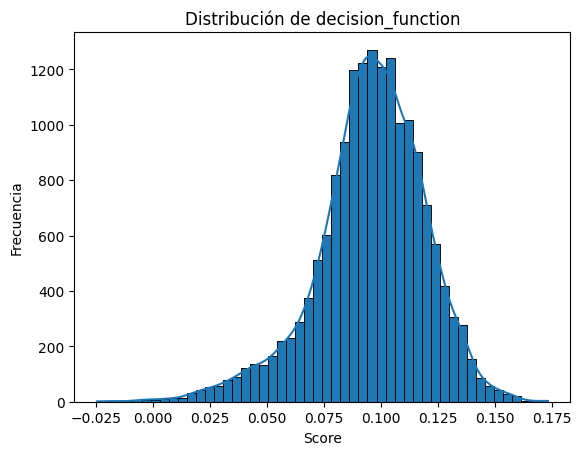

Test classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16546
           1       0.25      0.04      0.07       150

    accuracy                           0.99     16696
   macro avg       0.62      0.52      0.53     16696
weighted avg       0.98      0.99      0.99     16696

Matriz de Confusión:
[[16528    18]
 [  144     6]]
Precisión: 0.2500 | Recall: 0.0400 | F1-score: 0.0690


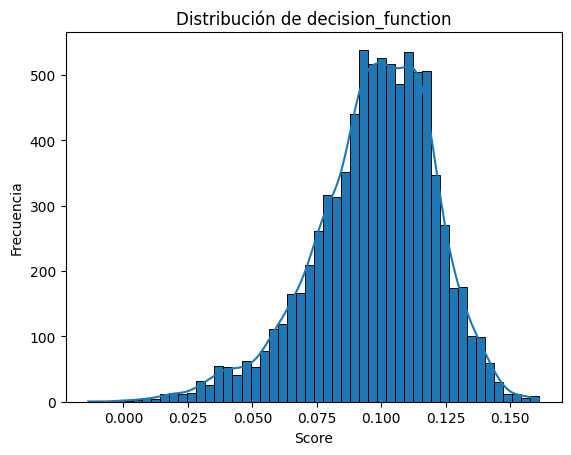

Test classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8316
           1       0.50      0.06      0.10        35

    accuracy                           1.00      8351
   macro avg       0.75      0.53      0.55      8351
weighted avg       0.99      1.00      0.99      8351

Matriz de Confusión:
[[8314    2]
 [  33    2]]
Precisión: 0.5000 | Recall: 0.0571 | F1-score: 0.1026

 **Procesando Cluster 8
Cluster 8 – Distribución de clases:
es_anomalia_IQR1_5
0    58128
1      312
Name: count, dtype: int64
Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


IsolationForest(contamination=0.001, n_estimators=50, random_state=42)


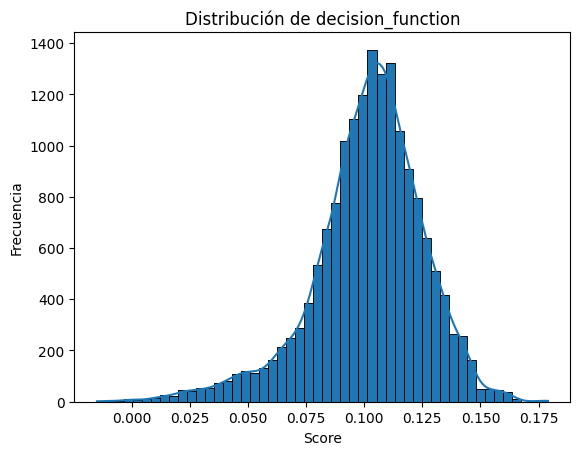

Test classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16581
           1       0.47      0.07      0.12       116

    accuracy                           0.99     16697
   macro avg       0.73      0.53      0.56     16697
weighted avg       0.99      0.99      0.99     16697

Matriz de Confusión:
[[16572     9]
 [  108     8]]
Precisión: 0.4706 | Recall: 0.0690 | F1-score: 0.1203


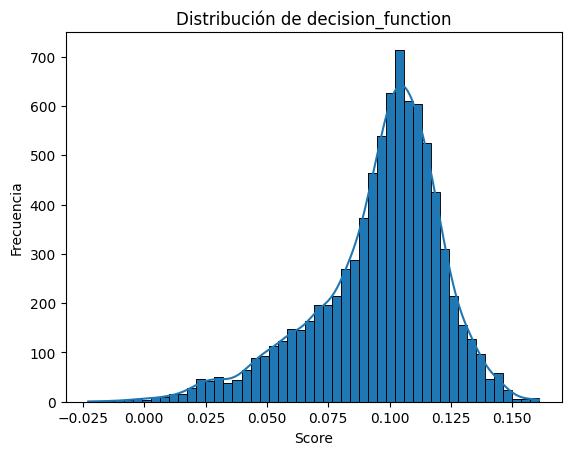

Test classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8254
           1       0.25      0.04      0.07        97

    accuracy                           0.99      8351
   macro avg       0.62      0.52      0.53      8351
weighted avg       0.98      0.99      0.98      8351

Matriz de Confusión:
[[8242   12]
 [  93    4]]
Precisión: 0.2500 | Recall: 0.0412 | F1-score: 0.0708


In [21]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer

import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

from sklearn.metrics import make_scorer, f1_score

def custom_anomaly_scorer(y_true, y_pred):
    # Convertir predicción -1 a 1 (anomalía), 1 a 0 (normal)
    y_pred_binary = (y_pred == -1).astype(int)
    return f1_score(y_true, y_pred_binary)

scorer = make_scorer(custom_anomaly_scorer, greater_is_better=True)

# Definir los parámetros para GridSearch
param_grid = {
    'iforest__n_estimators': [50, 100, 150],
    'iforest__max_samples': ['auto', 0.8],
    'iforest__contamination': [0.001, 0.005, 0.01, 0.02, 0.05], #[0.01, 0.03, 0.05, 0.08, 0.1]
    'iforest__max_features': [1.0, 0.8]
}

# Contenedor para los mejores modelos por cluster
modelos_cluster = {}

# definicion de columnas numéricas y categoricas a usar en el modelo
variables_numericas  = ['presion', 'volumen', 'temperatura', 'presion_volumen_ratio', 'temp_volumen_ratio', 'hora_pico']
variables_categoricas = ['mes', 'dia', 'hora']

variables_modelo = variables_numericas + variables_categoricas

df_procesamiento = pd.DataFrame()

# Preprocesamiento separado por tipo de variable
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), variables_numericas),
    ('cat', OneHotEncoder(drop='first'), variables_categoricas)
])

# Pipeline con escalado y modelo
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('iforest', IsolationForest(random_state=42))
])

# GridSearch sobre entrenamiento
# IsolationForest implementa .score(), que GridSearchCV usará automáticamente cuando scoring=None.
grid = GridSearchCV(pipe, param_grid, cv=3, scoring=scorer, n_jobs=-1, verbose=1)

for c in sorted(df['cluster'].unique()):
    print(f"\n **Procesando Cluster {c}")

    # Filtrar datos del cluster
    train_cluster = train[train['cluster'] == c].copy()
    test_cluster = test[test['cluster'] == c].copy()
    val_cluster = val[val['cluster'] == c].copy()

    # Ajustar usando solo variables del modelo
    X_train = train_cluster[variables_modelo]
    y_train = train_cluster['es_anomalia_IQR1_5']  # Solo para evaluación, no para .fit()

    counts = train_cluster['es_anomalia_IQR1_5'].value_counts()
    print(f"Cluster {c} – Distribución de clases:\n{counts}")

    # Solo continuar si hay al menos un valor de cada clase
    if 0 not in counts or 1 not in counts:
        print(f"⚠️ Cluster {c} descartado: clases no balanceadas.")
        continue

    grid.fit(X_train)

    # Guardar mejor modelo
    modelos_cluster[c] = grid.best_estimator_

    print(modelos_cluster[c].named_steps['iforest'])

    # Evaluación sobre test y validación
    for df_split, y_true, name in zip(
        [test_cluster[variables_modelo], val_cluster[variables_modelo]],
        [test_cluster['es_anomalia_IQR1_5'], val_cluster['es_anomalia_IQR1_5']],
        ['Test', 'Validación']
    ):
        y_pred_test = modelos_cluster[c].predict(df_split)

        # Convertir predicciones: -1 = anómalo, 1 = normal → binario
        y_pred_test = np.where(y_pred_test == -1, 1, 0)  # 1 = anomalía, 0 = normal

        scores = modelos_cluster[c].decision_function(df_split)

        # Asignar las columnas nuevas sin warnings
        df_split.loc[:, 'anomaly'] = y_pred_test
        df_split.loc[:, 'anomaly_score'] = scores
        df_split.loc[:, 'cluster'] = c

        # Visualizar la distribución de scores
        plt.hist(scores, bins=50)
        sns.histplot(scores, bins=50, kde=True)
        plt.title("Distribución de decision_function")
        plt.xlabel("Score")
        plt.ylabel("Frecuencia")
        plt.show()

        print("Test classification report:")
        print(classification_report(y_true, y_pred_test))

        # También puedes extraer y guardar las métricas si lo deseas
        cm = confusion_matrix(y_true, y_pred_test)
        precision = precision_score(y_true, y_pred_test)
        recall = recall_score(y_true, y_pred_test)
        f1 = f1_score(y_true, y_pred_test)

        print(f"Matriz de Confusión:\n{cm}")
        print(f"Precisión: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

In [ ]:
        # ---
        # Score de anomalía (cuanto más negativo, más anómalo)
        #scores = modelos_cluster[c].decision_function(df_split)

        # agregamos los resultados al DataFrame
        #df_split['anomaly'] = preds
        #df_split['anomaly_score'] = scores
        #df_split['cluster'] = c

        # Asignar las columnas nuevas sin warnings
        #df_split.loc[:, 'anomaly'] = y_pred_test
        #df_split.loc[:, 'anomaly_score'] = scores
        #df_split.loc[:, 'cluster'] = c

        # Visualizar la distribución de scores
        #plt.hist(scores, bins=50)
        #sns.histplot(scores, bins=50, kde=True)
        #plt.title("Distribución de decision_function")
        #plt.xlabel("Score")
        #plt.ylabel("Frecuencia")
        #plt.show()

        # Calcular umbral para el percentil deseado
        # Rangos de percentiles a evaluar
        #percentiles = [1, 2, 3, 5]

        #for percentil in percentiles:
            # Calcular umbral para el percentil deseado
        #    threshold = np.percentile(scores, percentil)
        #    print(f"\n--- Percentil: {percentil}% ---")
        #    print(f"Umbral del {percentil}% más bajo: {threshold:.6f}")

            # Separar anomalías y normales
        #    anomalies_ = df_split[scores < threshold]
        #    normal_points_ = df_split[scores >= threshold]

            # Mostrar resultados
        #    total = len(df_split)
        #    num_anom = len(anomalies_)
        #    porcentaje_anom = num_anom / total * 100
        #    print(f"Total de anomalías detectadas: {num_anom} ({porcentaje_anom:.2f}%)")

        #percentiles = list(range(1, 5))
        #n_anomalies = [len(df_split[scores < np.percentile(scores, p)]) for p in percentiles]

        #for p, n in zip(percentiles, n_anomalies):
        #    print(f"Percentil: {p}% - Anomalías detectadas: {n}")

        #plt.plot(percentiles, n_anomalies, marker='o')
        #plt.title("Método del Codo - Anomalías vs Percentil")
        #plt.xlabel("Percentil (más bajo)")
        #plt.ylabel("Cantidad de anomalías detectadas")
        #plt.grid()
        #plt.show()

        # ---

        #if name == 'Validación':
        #    base_isfr_validacion = pd.concat([base_isfr_validacion, df_split], ignore_index=True)

        #print(f"\n Resultados para Cluster {c} en {name}")
        #print(f"Total de muestras: {len(df_split)}")
        #print(f"Anomalías detectadas: {y_pred_test.sum()}")
        #print(f"Porcentaje de anomalías: {round(100 * y_pred_test.sum() / len(y_pred_test), 2)}%")

        # --------- Plot 1: Scatter presión vs volumen con color por anomalía ---------
        #plt.figure(figsize=(10, 5))
        #colors = df_split['anomaly'].map({0: 'blue', 1: 'red'})  # normales en azul, anomalia en rojo

        #plt.scatter(df_split['presion'], df_split['volumen'], c=colors, alpha=0.5)
        #plt.xlabel('Presión')
        #plt.ylabel('Volumen')
        #plt.title(f'Detección de Anomalías (Isolation Forest) para el cluster {c} en {name}')
        #plt.grid(True)
        #plt.show()

        # --------- Plot 2: Distribución de los scores de anomalía ---------
        #plt.figure(figsize=(8, 4))
        #sns.histplot(df_split['anomaly_score'], bins=50, kde=True)

        # Cuantil de score extremo (por ejemplo, 5%)
        #cuantil_05 = df_split['anomaly_score'].quantile(0.05)
        #print(f"Cuantil: {cuantil_05}%")
        #plt.axvline(cuantil_05, c='red', linestyle='--', label='cuantil 0.01')

        #plt.title(f'Distribución del puntuaciones de Anomalía para el cluster {c} en {name}')
        #plt.xlabel('Puntuaciones de anomalía')
        #plt.ylabel("Frecuencia")
        #plt.grid(True)
        #plt.show()

En un contexto no supervisado, con Isolation Forest y datos sin etiquetas, no es posible optimizar el percentil de corte con métricas clásicas como precisión o recall. Por lo cual usamos criterios estadísticos y visuales para elegir un umbral más justificado.

*Dado que los datos son no etiquetados y la distribución de puntuaciones de anomalía es aproximadamente normal, seleccionamos el umbral de anomalía como el percentil 5% inferior. Este enfoque busca capturar los valores significativamente más atípicos, manteniendo un balance entre sensibilidad y tasa de falsos positivos.*

# Evaluación de los modelos de detección de anomalías

En esta sección se evalúan los modelos **Isolation Forest** entrenados previamente para cada uno de los N clusters identificados.

Dado que el conjunto de datos **no cuenta con etiquetas que indiquen si un registro es anómalo o no**, no es posible calcular métricas de evaluación propias de modelos supervisados, como:

- **Precisión** (`Precision`)
- **Sensibilidad o Recall** (`Recall`)
- **Puntaje F1** (`F1-score`)
- **Matriz de confusión`**

En su lugar, la evaluación se enfoco en:

- La **cantidad de anomalías detectadas** por cluster.
- La **distribución de puntuaciones de anomalía**.
- **Visualizaciones** que permitan analizar el comportamiento del modelo y detectar patrones o posibles errores.

> Esta evaluación permitio obtener una comprensión exploratoria de la eficacia de los modelos en contextos donde no se dispone de etiquetas reales.


In [ ]:
# Guardar el resultado en un nuevo archivo
base_isfr_validacion.to_parquet("base_isfr_validacion.parquet", index=False)
base_isfr_validacion.to_csv("base_isfr_validacion.csv", index=False)

print("Archivo consolidado guardado")

Archivo consolidado guardado
